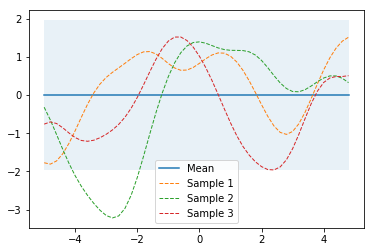

In [65]:
import numpy as np
import matplotlib.pyplot as plt

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    ''' Isotropic squared exponential kernel. Computes a covariance matrix from points in X1 and X2. Args: X1: Array of m points (m x d). X2: Array of n points (n x d). Returns: Covariance matrix (m x n). '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)


# Prior
%matplotlib inline

from gaussian_processes_util import plot_gp

# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)


# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)

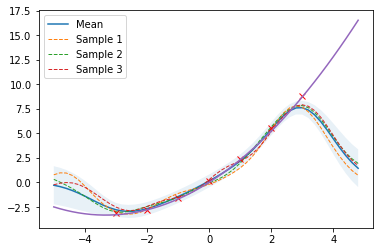

In [66]:
# Prediction from noise-free training data

from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    ''' Computes the suffifient statistics of the GP posterior predictive distribution from m training data X_train and Y_train and n new inputs X_s. Args: X_s: New input locations (n x d). X_train: Training locations (m x d). Y_train: Training targets (m x 1). l: Kernel length parameter. sigma_f: Kernel vertical variation parameter. sigma_y: Noise parameter. Returns: Posterior mean vector (n x d) and covariance matrix (n x n). '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s


# training data with noise
noise = 0.4
# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = 2.*X_train+0.3*X_train**2 + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

plt.plot(X,2.*X+0.3*X**2)

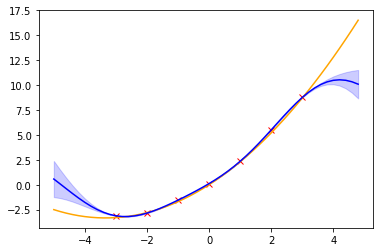

In [67]:
from sklearn.datasets import load_iris
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

kernel = ConstantKernel() + 1.0 * RBF(1)+ WhiteKernel(noise_level=noise)
gpc = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20).fit(X_train, Y_train)
gpc.score(Y_train, Y_train) 

Y, sigma = gpc.predict(X, return_std=True)

plt.plot(X_train, Y_train, 'x', color='r')
plt.plot(X,2.*X+0.3*X**2, color='orange')

X0 = X.ravel()
Y0 = Y.ravel()
sigma0 = sigma.ravel()
plt.plot(X0,Y0, color='blue')
plt.fill_between(X0,Y0+1.96*sigma0, Y0-1.96*sigma0, alpha=.2, color='blue', label='95% confidence interval')

In [68]:
print(gpc.log_marginal_likelihood_value_)

-7.59432716653432


      fun: 6.8481941453020925
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([50863565.88083163])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 22
      nit: 2
   status: 0
  success: True
        x: array([0.97804072])
0.9780407158659742


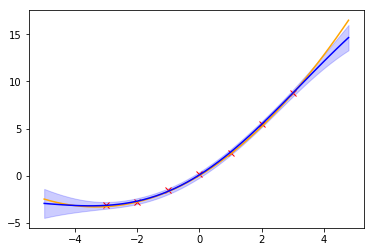

In [69]:
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise):
    ''' Returns a function that computes the negative log-likelihood for training data X_train and Y_train and given noise level. Args: X_train: training locations (m x d). Y_train: training targets (m x 1). noise: known noise level of Y_train. Returns: Minimization objective. '''
    def step(theta):
        
        Y_train_d = Y_train-theta[0]*X_train
        
        kernel = ConstantKernel() + 1.0 * RBF(1)+ WhiteKernel(noise_level=noise)
        gpc = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20).fit(X_train, Y_train_d)
        gpc.score(Y_train, Y_train_d) 
        
        return -1.0*gpc.log_marginal_likelihood_value_
        
    
    return step


res = minimize(nll_fn(X_train, Y_train, noise), [3], method='L-BFGS-B')

print(res)

theta = res.x
theta = theta[0]
print theta

Y_train_d = Y_train-theta*X_train
kernel = ConstantKernel() + 1.0 * RBF(1)+ WhiteKernel(noise_level=noise)
gpc = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20).fit(X_train, Y_train_d)
gpc.score(Y_train, Y_train_d) 


Y, sigma = gpc.predict(X, return_std=True)

plt.plot(X_train, Y_train, 'x', color='r')
plt.plot(X,2.*X+0.3*X**2, color='orange')

X0 = X.ravel()
Y += theta*X
Y0 = Y.ravel()
sigma0 = sigma.ravel()
plt.plot(X0,Y0, color='blue')
plt.fill_between(X0,Y0+1.96*sigma0, Y0-1.96*sigma0, alpha=.2, color='blue', label='95% confidence interval')